In [0]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import count
from scipy import ndimage
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm
import tensorflow_addons as tfa

In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 28
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_augment"
PATH = ""

# Set seeds

In [0]:
np.random.seed(3)
tf.random.set_seed(3)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def FashionMNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = "same")(x)
    x = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters = 10, kernel_size = (1,1),strides = (1,1), padding = 'valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Data augmentation functions


In [0]:
def flip_image(image):
    if np.random.rand() < 0.2:
        image = tf.image.flip_left_right(image)
    return image

In [0]:
def rotate_image(image):
    if np.random.rand() < 0.2:
        angles = np.linspace(1,10,10)
        rotation_angle = np.random.choice(angles)
        if np.random.rand() < 0.5:
            image = ndimage.rotate(image, rotation_angle, reshape = False)
        else:
            image = ndimage.rotate(image, -rotation_angle, reshape = False) 
    return image

In [0]:
def horizontal_shift(image):
    if np.random.rand() < 0.2:
        num_rows, num_cols = image.shape[:2]
        if np.random.rand() < 0.5:
            translation_matrix = np.float32([ [1,0,3], [0,1,0] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        else:
            translation_matrix = np.float32([ [1,0,-3], [0,1,0] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
    return image

In [0]:
def vertical_shift(image):
    if np.random.rand() < 0.2:
        num_rows, num_cols = image.shape[:2]
        if np.random.rand() < 0.5:
            translation_matrix = np.float32([ [1,0,0], [0,1,2] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        else:
            translation_matrix = np.float32([ [1,0,0], [0,1,-2] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
    return image

In [0]:
funcs = [rotate_image,
         horizontal_shift, 
         vertical_shift]

# Train

In [0]:
models = []
accuracies = [0]

for i in range(len(funcs)):

    print(f"Train model {i}")

    preprocessing_function = funcs[i]
    datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    datagen = datagen.flow(x_train,y_train, batch_size = BATCH_SIZE)

    model = FashionMNISTmodel(IMAGE_SIZE, NUM_CLASSES, 1)

    es = EarlyStopping(min_delta = 0.01, patience=3)
    model.fit_generator(datagen,
                        epochs = EPOCHS,
                        validation_data = (x_test,y_test),
                        shuffle = True,
                        callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")

Train model 0
Epoch 1/9999
375/375 [==============================] - 7s 19ms/step - loss: 2.2553 - accuracy: 0.1421 - val_loss: 2.2529 - val_accuracy: 0.2697
Epoch 2/9999
375/375 [==============================] - 7s 18ms/step - loss: 2.0980 - accuracy: 0.3293 - val_loss: 2.0270 - val_accuracy: 0.3573
Epoch 3/9999
375/375 [==============================] - 7s 18ms/step - loss: 1.9488 - accuracy: 0.3727 - val_loss: 1.8662 - val_accuracy: 0.4096
Epoch 4/9999
375/375 [==============================] - 7s 18ms/step - loss: 1.8234 - accuracy: 0.4013 - val_loss: 1.7494 - val_accuracy: 0.4436
Epoch 5/9999
375/375 [==============================] - 7s 18ms/step - loss: 1.7269 - accuracy: 0.4227 - val_loss: 1.6620 - val_accuracy: 0.4651
Epoch 6/9999
375/375 [==============================] - 7s 18ms/step - loss: 1.6520 - accuracy: 0.4472 - val_loss: 1.5902 - val_accuracy: 0.4674
Epoch 7/9999
375/375 [==============================] - 7s 18ms/step - loss: 1.5912 - accuracy: 0.4684 - val_loss: 1

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Model: 0 added. Resulting score: 0.721
Train model 1
Epoch 1/9999
375/375 [==============================] - 4s 10ms/step - loss: 2.2548 - accuracy: 0.1556 - val_loss: 2.2652 - val_accuracy: 0.2379
Epoch 2/9999
375/375 [==============================] - 4s 9ms/step - loss: 2.1354 - accuracy: 0.3148 - val_loss: 2.0791 - val_accuracy: 0.3405
Epoch 3/9999
375/375 [==============================] - 4s 9ms/step - loss: 1.9996 - accuracy: 0.3577 - val_loss: 1.9201 - val_accuracy: 0.3598
Epoch 4/9999
375/375 [==============================] - 4s 9ms/step - loss: 1.8656 - accuracy: 0.3929 - val_loss: 1.7913 - val_accuracy: 0.4136
Epoch 5/9999
375/375 [==============================] - 4s 9ms/step - loss: 1.7545 - accuracy: 0.4283 - val_loss: 1.6912 - val_accuracy: 0.4411
Epoch 6/9999
375/375 [==============================] - 4s 9ms/step - loss: 1.6677 - accuracy: 0.4512 - val_loss: 1.6121 - val_accuracy: 0.4742
Epoch 7/9999
375/375 [==============================] - 4s 9ms/step - loss: 1.5998

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Model: 1 added. Resulting score: 0.7176666666666667
Train model 2
Epoch 1/9999
375/375 [==============================] - 4s 10ms/step - loss: 2.2929 - accuracy: 0.1362 - val_loss: 2.2781 - val_accuracy: 0.1652
Epoch 2/9999
375/375 [==============================] - 4s 9ms/step - loss: 2.1979 - accuracy: 0.2953 - val_loss: 2.1459 - val_accuracy: 0.3466
Epoch 3/9999
375/375 [==============================] - 3s 9ms/step - loss: 2.0751 - accuracy: 0.3833 - val_loss: 1.9809 - val_accuracy: 0.3800
Epoch 4/9999
375/375 [==============================] - 3s 9ms/step - loss: 1.9242 - accuracy: 0.3988 - val_loss: 1.8298 - val_accuracy: 0.4282
Epoch 5/9999
375/375 [==============================] - 3s 9ms/step - loss: 1.7907 - accuracy: 0.4261 - val_loss: 1.7105 - val_accuracy: 0.4673
Epoch 6/9999
375/375 [==============================] - 3s 9ms/step - loss: 1.6890 - accuracy: 0.4520 - val_loss: 1.6202 - val_accuracy: 0.4765
Epoch 7/9999
375/375 [==============================] - 3s 9ms/step -

100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

Model: 2 added. Resulting score: 0.74975


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensemble

In [0]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.000000,0
1,0.721000,1
2,0.717667,2
3,0.749750,3


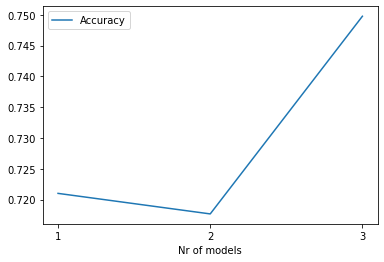

In [0]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [0]:
print("Accuracy: " + str(predict(models, x_test, y_test)))

100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

Accuracy: 0.76


In [0]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))



100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


## Correlation between models

In [0]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,np.argmax(y_test, axis = 1))])

100%|██████████| 3/3 [00:00<00:00, 214.16it/s]


In [0]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2
0,NaN,0.839513,0.845599
1,0.839513,NaN,0.831005
2,0.845599,0.831005,NaN


Average correlation: 0.8387056180281784
